# test AlphaGenome

Welcome to the quick start guide for AlphaGenome! The goal of this tutorial notebook is to quickly get you started with using the model and making predictions.

```{tip}
Open this tutorial in Google colab for interactive viewing.
```

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [2]:
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
from alphagenome.data.genome import Interval
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import userdata

## Predict outputs for a DNA sequence

AlphaGenome is a model that makes predictions from DNA sequences. Let's load it up:



In [22]:
dna_model = dna_client.create(userdata.get('ALPHA_GENOME_API_KEY'))

The model can make predictions for the following [output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [13]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

The `output` object contains predictions for all the different requested output types (in this case, only output type `DNASE`). Predictions for genomic tracks are stored inside a `TrackData` object:                                                                                                                            

## Predict outputs for a genome interval (reference genome)

For convenience, you can also directly make predictions for a human reference genome sequence specified by a **genomic interval**. For example, let's predict RNA-seq for tissue 'Right liver lobe' in a 1MB region of Chromosome 19 around the gene *CYP2B6*, which encodes an enzyme involved in drug metabolism, and is primarily expressed in the liver.

We first load up a GTF file containing gene and transcript locations as annotated by GENCODE (more information on GTF format [here](https://www.gencodegenes.org/pages/data_format.html)):

In [14]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

And then fetch the gene's location as a `genome.Interval` object by passing either its `gene_symbol` (HGNC naming convention) or ENSEMBL `gene_id`:

In [15]:
#interval = gene_annotation.get_gene_interval(gtf, gene_symbol='RUNX1')
interval = Interval("chr21",34774510,35131107)

In [16]:
dna_client.SEQUENCE_LENGTH_500KB

524288

We can resize it to a length compatible with the model:

In [17]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_500KB)

In [18]:
interval.width

524288

 See the [essential commands documentation](https://www.alphagenomedocs.com/colabs/essential_commands.html) for more handy commands like `resize`.

Note that AlphaGenome supports the following input sequence lengths:

In [19]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_2KB', 'SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])


 We can now make predictions using our interval:

In [30]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.ATAC],
    ontology_terms=["EFO:0002067","EFO:0002784"], #K562,GM12878
)

output.atac.values.shape

(524288, 2)

In [31]:
output.atac

TrackData(values=array([[0.01538086, 0.01806641],
       [0.08300781, 0.11279297],
       [0.00756836, 0.0088501 ],
       ...,
       [0.00460815, 0.00236511],
       [0.00230408, 0.0009613 ],
       [0.01196289, 0.00689697]], dtype=float32), metadata=                   name strand Assay title ontology_curie biosample_name  \
0  EFO:0002067 ATAC-seq      .    ATAC-seq    EFO:0002067           K562   
1  EFO:0002784 ATAC-seq      .    ATAC-seq    EFO:0002784        GM12878   

  biosample_type biosample_life_stage data_source endedness  \
0      cell_line                adult      encode    paired   
1      cell_line                adult      encode    paired   

   genetically_modified  
0                 False  
1                 False  , resolution=1, interval=Interval(chromosome='chr21', start=34690665, end=35214953, strand='.', name=''), uns=None)

In general, you can have multiple tracks for a given ontology term. In this case, we have 3 RNA-seq tracks for the tissue "Right liver lobe".

Let's visualise these predictions. It's helpful visualise gene transcripts alongside the predicted tracks, so we extract them here:

In [32]:
longest_transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(longest_transcripts)} transcripts in this interval.')

Extracted 2 transcripts in this interval.


We also provide a [visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html) that integrates nicely with `TrackData` and other objects returned by the model API.

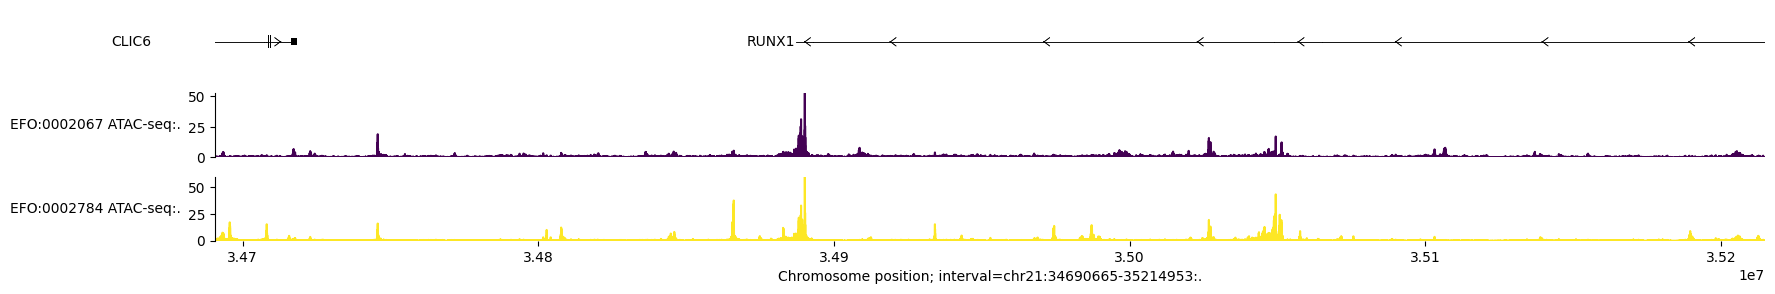

In [33]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(output.atac),
    ],
    interval=output.atac.interval,
)

plt.show()

In [34]:
minterval = Interval("chr11",53591728,53749228) #mice Il2 locus

In [35]:
minterval = minterval.resize(dna_client.SEQUENCE_LENGTH_500KB)

## Making mouse predictions

In [58]:
output = dna_model.predict_interval(
    interval=minterval,
    organism=dna_client.Organism.MUS_MUSCULUS,
    requested_outputs=[dna_client.OutputType.DNASE],
    ontology_terms=["CL:0000492","CL:0000236 "], #Th2 cell
)


In [52]:
output.dnase

TrackData(values=array([[0.00564575],
       [0.00531006],
       [0.00582886],
       ...,
       [0.0402832 ],
       [0.02160645],
       [0.01635742]], dtype=float32), metadata=                   name strand Assay title ontology_curie  \
0  CL:0000492 DNase-seq      .   DNase-seq     CL:0000492   

               biosample_name biosample_type biosample_life_stage data_source  \
0  CD4-positive helper T cell   primary_cell                adult      encode   

  endedness  genetically_modified  
0    paired                 False  , resolution=1, interval=Interval(chromosome='chr11', start=53408334, end=53932622, strand='.', name=''), uns=None)

In [55]:
mgtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'mm10/gencode.vM23.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
mgtf_transcripts = gene_annotation.filter_protein_coding(mgtf)
mgtf_transcripts = gene_annotation.filter_to_longest_transcript(mgtf_transcripts)
mtranscript_extractor = transcript_utils.TranscriptExtractor(mgtf_transcripts)

In [60]:
mlongest_transcripts = mtranscript_extractor.extract(minterval)

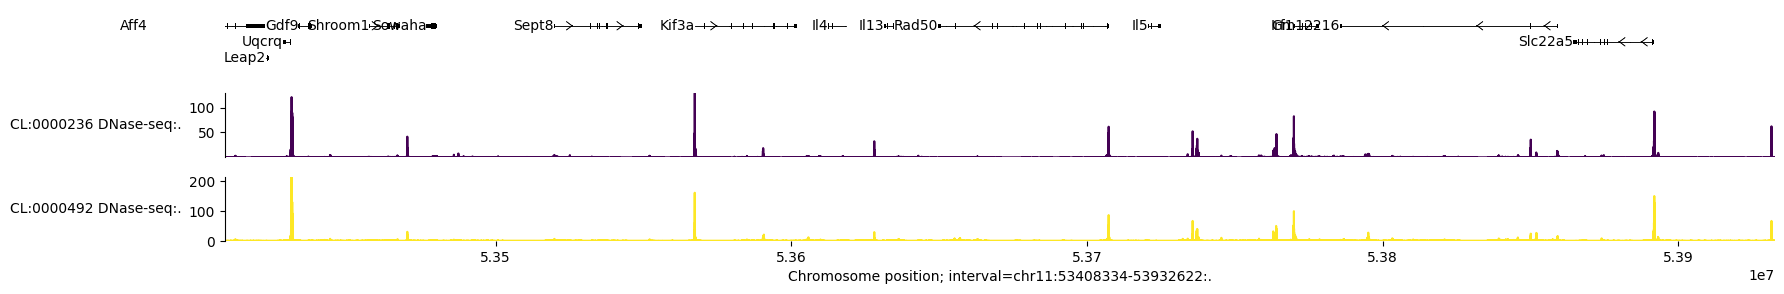

In [61]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(mlongest_transcripts),
        plot_components.Tracks(output.dnase),
    ],
    interval=output.dnase.interval,
)

plt.show()

And here is an example of calling `predict_interval` for a mouse genomic interval: